In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras import models, layers, optimizers
import numpy as np
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [4]:
# Execution flags
RUNNING_ON_FLOYDHUB = True
epochs = 100

In [5]:
if not RUNNING_ON_FLOYDHUB:
    train_dir = 'data/dogs-vs-cats-small/train/'
    test_dir = 'data/dogs-vs-cats-small/test/'
    validation_dir = 'data/dogs-vs-cats-small/validation/'
    output_dir = './'
else:
    # Make sure the mount point is /data
    train_dir = '/data/dogs-vs-cats-small/train/'
    test_dir = '/data/dogs-vs-cats-small/test/'
    validation_dir = '/data/dogs-vs-cats-small/validation/'
    output_dir = '/output/'
save_path = os.path.join(output_dir, 'cats_vs_dogs_vgg_data_finetune_augmentation.h5')

In [6]:
# Create augmented data generator
train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  fill_mode='nearest',
                                  horizontal_flip=True,
                                  rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255) # Test data should not be augmented

In [7]:
train_batches = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), class_mode='binary', batch_size=20)
validation_batches = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), class_mode='binary', batch_size=20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
num_of_training_examples = 2000
num_of_validation_examples = 1000

### Model

In [9]:
#Convolutional base
conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [10]:
model = models.Sequential()
model.add( conv_base )
model.add( layers.Flatten() )
model.add( layers.Dense(256, activation='relu') )
model.add( layers.Dense(1, activation='sigmoid') )

In [15]:
print('Num of trainable weights before freezing convolutional base = {}'.format( len(model.trainable_weights) ))
for layer in conv_base.layers:
    if 'block5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False
    print(layer.name, layer.trainable)
print('Num of trainable weights after freezing convolutional base = {}'.format( len(model.trainable_weights) ))

Num of trainable weights before freezing convolutional base = 30
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
Num of trainable weights after freezing convolutional base = 10


In [17]:
model.compile( optimizer=optimizers.RMSprop(lr=1e-5), loss='binary_crossentropy', metrics=['acc'])

In [18]:
history = model.fit_generator( train_batches, steps_per_epoch=100, epochs=epochs, validation_data=validation_batches, validation_steps=50)

Epoch 1/1
100/100 [==============================] - 1397s 14s/step - loss: 0.5331 - acc: 0.7365 - val_loss: 0.3266 - val_acc: 0.8670


In [14]:
model.save(save_path)

### Plots

In [19]:
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

train_loss = history.history['loss']
train_acc = history.history['acc']

epoch = history.epoch

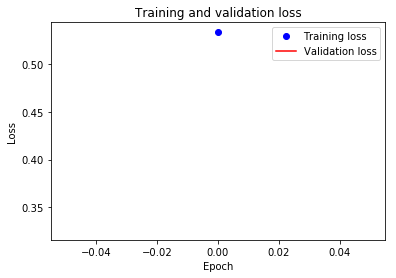

In [20]:
# Loss plots
plt.figure()

plt.plot(epoch, train_loss, 'bo', label='Training loss')
plt.plot(epoch, val_loss, 'r-', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

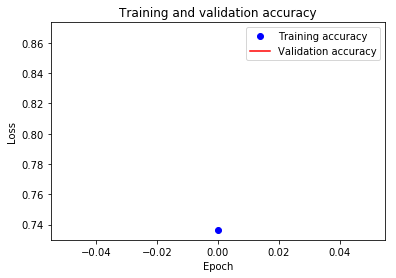

In [21]:
# Accuracy plots
plt.figure()

plt.plot( epoch, train_acc, 'bo', label='Training accuracy' )
plt.plot( epoch, val_acc, 'r-', label='Validation accuracy' )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [24]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), class_mode='binary', batch_size=20)

Found 1000 images belonging to 2 classes.


In [25]:
test_loss, test_acc = model.evaluate_generator( test_generator, steps=50 )
print('Test accuracy = {0:.3f}'.format(test_acc))

Test accuracy = 0.849
